To reproduce this experiment, the following commands need to be run:

```shell
for i in {1..5}; do poetry run python -m project.main --config-name=mnist use_wandb=true strategy=afl fed="mnist_$i" task="mnist"; done
for i in {1..5}; do poetry run python -m project.main --config-name=mnist use_wandb=true strategy=afl fed="mnist_all_$i" task="mnist"; done
for i in {1..5}; do poetry run python -m project.main --config-name=mnist use_wandb=true strategy=fedavg fed="mnist_$i" task="mnist"; done
for i in {1..5}; do poetry run python -m project.main --config-name=mnist use_wandb=true strategy=fedavg fed="mnist_all_$i" task="mnist"; done
```

The results of the runs should be renamed on wandb in this order:
1. f"afl_{i}_compare_bugfree_high_lr" - e.g. afl_5_compare_bugfree_high_lr
2. f"afl_{i}_lr_schedule_all"
3. f"fedavg_{i}_compare_high_lr"
4. f"fedavg_{i}_lr_schedule_all"

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import wandb
from pathlib import Path
from plotting.wandb_utils import get_filtered_runs

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = [
    "Times New Roman",
] + plt.rcParams["font.serif"]
sns.set_style("whitegrid")
CB_color_cycle = [
    "#377EB8",
    "#FF7F00",
    "#4DAF4A",
    "#F781BF",
    "#A65628",
    "#984EA3",
    "#999999",
    "#E41A1C",
    "#DEDE00",
]

We get the data from Weights and Biases

In [2]:
api = wandb.Api()
entity, project = "kornelszabo", "template"

artifacts = get_filtered_runs(
    lambda run: (
        "lr_schedule_all" in run.name
        or "compare_high_lr" in run.name
        or "compare_bugfree_high_lr" in run.name
    ),
    api=api,
    entity=entity,
    project=project,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb:   1 of 1 files downloaded.  
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
wandb:   1 of 1 files downloaded.  
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


We format the dataframes and plot the fairness metrics.

In [3]:
def name_from_row(row):
    return (
        f"{row.split('_')[0]} | clients_per_round = {'5' if 'compare' in row else '10'}"
    )

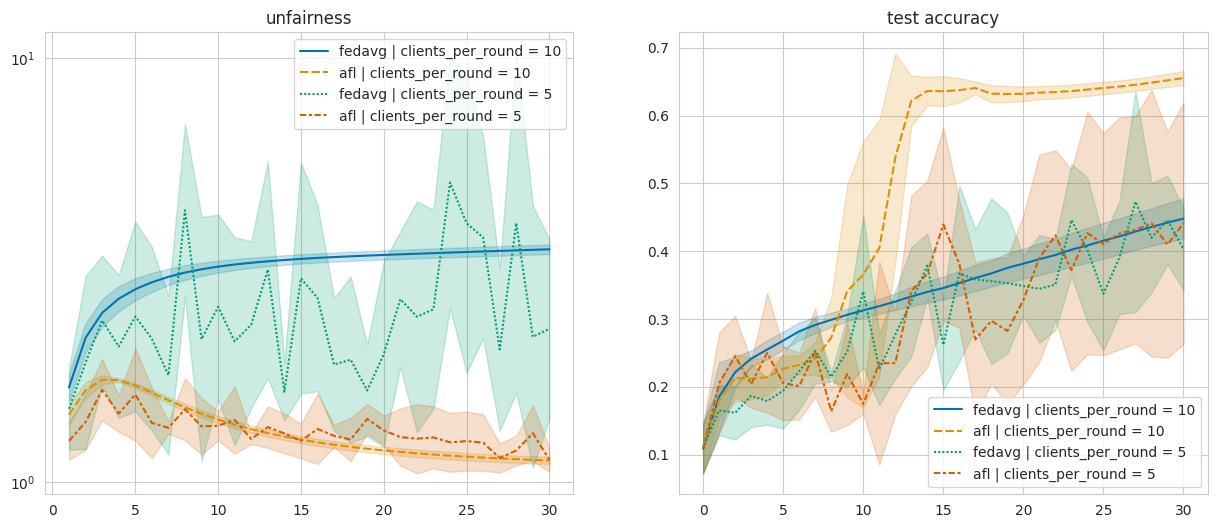

In [5]:
train = pd.DataFrame(
    np.array(
        [v.train_loss_max.div(v.train_loss).values[:31] for v in artifacts.values()]
    ).T,
    columns=[name_from_row(name) for name in artifacts],
)

test = pd.DataFrame(
    np.array([v.test_accuracy.values[:31] for v in artifacts.values()]).T,
    columns=[name_from_row(name) for name in artifacts],
)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))  # , sharey=True)
ax[0].set_yscale("log")
sns.lineplot(train, errorbar="sd", palette="colorblind", ax=ax[0]).set_title(
    "unfairness"
)
sns.lineplot(test, errorbar="sd", palette="colorblind", ax=ax[1]).set_title(
    "test accuracy"
)


plt.savefig("./plots/exp_3.png", bbox_inches="tight")

We perform Welch's t-test on the on the unfairness metrics at the end of the training loop.

In [7]:
data = train.iloc[-1].rename("ratio").reset_index().groupby("index").ratio.agg(list)
data

print(
    scipy.stats.ttest_ind(
        data.loc["afl | clients_per_round = 5"],
        data.loc["fedavg | clients_per_round = 5"],
    )
)
scipy.stats.ttest_ind(
    data.loc["afl | clients_per_round = 10"],
    data.loc["fedavg | clients_per_round = 10"],
)

TtestResult(statistic=-2.646282880370558, pvalue=0.029425023812847055, df=8.0)


TtestResult(statistic=-51.43514226426666, pvalue=2.2616099095835002e-11, df=8.0)